In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import re

pd.set_option('display.max_columns', 500)

# For plotting
from itertools import cycle

plt.style.use("ggplot")
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Load in the Dataset and Parse Tweet Text

In [2]:
tweets = pd.read_csv('../input/pull-wordle-tweets/updated/tweets.csv')

In [3]:
def process_tweets(tweets):
    tweets['tweet_dateTime'] = pd.to_datetime(tweets['tweet_date'])
    tweets['tweet_date'] = tweets['tweet_dateTime'].dt.date
    tweets['wordle_id'] = tweets['tweet_text'].str[:10]
    tweets['n_attempts'] = tweets['tweet_text'].str[11].astype('int')
    tweets['id'] = tweets['tweet_text'].str[7:10].astype('int')
    return tweets

tweets = process_tweets(tweets)

## How many tweets do we have for each date

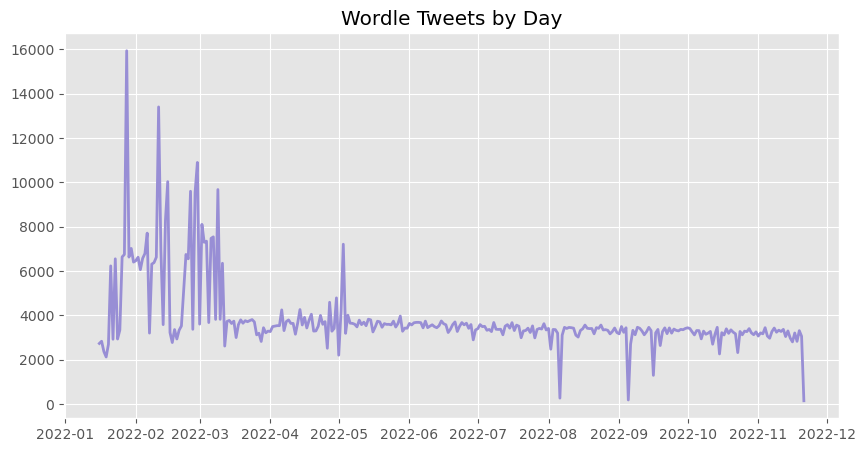

In [4]:
tweets['tweet_date'].value_counts().plot(figsize=(10,5), title='Wordle Tweets by Day', color=color_pal[2], lw=2)
plt.show()

## Number of Attempts analysis

In [5]:
tweets.head()

,wordle_id,tweet_id,tweet_date,tweet_username,tweet_text,tweet_dateTime,n_attempts,id
0,Wordle 210,1482553374591660037,2022-01-16,bpszebes,Wordle 210 4/6\n\n⬛⬛🟨🟨⬛\n🟩⬛⬛⬛⬛\n🟩🟩🟨⬛⬛\n🟩🟩🟩🟩🟩,2022-01-16 03:20:43+00:00,4,210
1,Wordle 210,1482553387937898499,2022-01-16,cruisecoup,Wordle 210 4/6\n\n⬜⬜⬜⬜⬜\n🟩🟩🟨🟨⬜\n🟩🟩⬜🟩🟨\n🟩🟩🟩🟩🟩,2022-01-16 03:20:46+00:00,4,210
2,Wordle 210,1482553422276698113,2022-01-16,DestroVega,Wordle 210 4/6\n\n⬜⬜⬜🟨⬜\n⬜🟩⬜🟨⬜\n⬜🟩⬜🟨⬜\n🟩🟩🟩🟩🟩,2022-01-16 03:20:55+00:00,4,210
3,Wordle 210,1482553436910628866,2022-01-16,brenmardash,Wordle 210 3/6\n\n⬜⬜🟨⬜⬜\n🟨🟨⬜⬜⬜\n🟩🟩🟩🟩🟩,2022-01-16 03:20:58+00:00,3,210
4,Wordle 210,1482553445726908420,2022-01-16,KatieHowse2,Wordle 210 3/6\n\n⬛⬛🟨⬛⬛\n🟩🟩🟩⬛⬛\n🟩🟩🟩🟩🟩,2022-01-16 03:21:00+00:00,3,210


In [6]:
tweets.groupby('wordle_id')['n_attempts'].value_counts().unstack().style.background_gradient(axis=1)

n_attempts,2,3,4,5,6
wordle_id,,,,,
Wordle 210,222,897,1064,489,165
Wordle 211,196,903,1016,564,215
Wordle 212,191,787,820,413,188
Wordle 213,51,260,630,697,481
Wordle 214,383,1012,823,363,122
Wordle 215,246,877,1017,579,224
Wordle 216,461,1952,2078,1199,415
Wordle 217,102,566,1031,843,418
Wordle 218,170,1009,1384,730,187


# How many attempts does it usually take to solve?

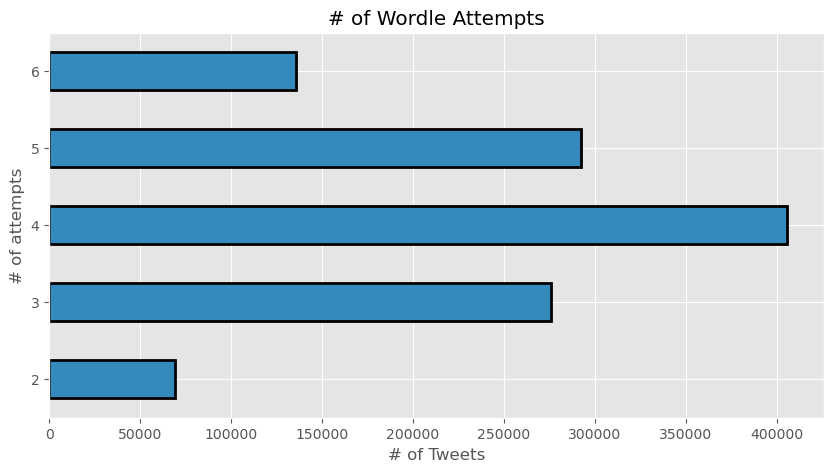

In [7]:
ax = tweets['n_attempts'].value_counts().sort_index().plot(kind='barh',figsize=(10,5), title='# of Wordle Attempts',edgecolor='black', color=color_pal[1], lw=2)
ax.set_ylabel('# of attempts')
ax.set_xlabel('# of Tweets')
plt.show()

# Parse Tweet Text

In [8]:
# Make Dark squares consistent
tweets['tweet_text'] = tweets['tweet_text'].str.replace('⬜','⬛')

In [9]:
def parse_tweet_text(tweets):
    for n in range(6):
        n += 1
        tweets[f'has_guess{n}'] = tweets['tweet_text'].str.split('\n').str[n+1] \
            .str.contains('|'.join(['🟨','⬛','🟩'])) \
            .fillna(False)

        # Parse out the tweet text
        tweets.loc[tweets[f'has_guess{n}'], f'guess{n}'] = \
                tweets['tweet_text'].str.split('\n').str[n + 1].str[:5]
        # Count number correct, misplaced, and incorrect
        tweets.loc[tweets[f'has_guess{n}'],f'guess{n}_incorrect'] = tweets[f'guess{n}'].str.count('⬛')
        tweets.loc[tweets[f'has_guess{n}'],f'guess{n}_wrong_spot'] = tweets[f'guess{n}'].str.count('🟨')
        tweets.loc[tweets[f'has_guess{n}'],f'guess{n}_correct'] = tweets[f'guess{n}'].str.count('🟩')
        tweets.loc[tweets[f'guess{n}_correct'] == 6, 'final_guess'] = n
    return tweets

tweets = parse_tweet_text(tweets)

/tmp/ipykernel_20/1381046247.py:12: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  tweets.loc[tweets[f'has_guess{n}'],f'guess{n}_incorrect'] = tweets[f'guess{n}'].str.count('⬛')
/tmp/ipykernel_20/1381046247.py:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  tweets.loc[tweets[f'has_guess{n}'],f'guess{n}_wrong_spot'] = tweets[f'guess{n}'].str.count('🟨')
/tmp/ipykernel_20/1381046247.py:14: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain 

In [10]:
tweets = tweets.drop(['guess1_incorrect', 'guess1_wrong_spot', 'guess1_correct', 'guess1'])

KeyError: "['guess1_incorrect', 'guess1_wrong_spot', 'guess1_correct', 'guess1'] not found in axis"

In [ ]:
tweets

In [ ]:
# Keep additional tweet text
tweets['additional_text'] = tweets.loc[~tweets['tweet_text'].str.split('\n').str[-1].str.contains('🟩')]['tweet_text'].str.split('\n').str[-1]

# Plot Result by Attempt

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 5), sharex=True)

for i, x in enumerate(['_correct','_wrong_spot','_incorrect']):
    col_subset = [c for c in tweets.columns if x in c]
    guess_avg = tweets[col_subset].mean()
    guess_avg.index = [f'Guess {i+1}' for i in range(6)]
    guess_avg.sort_index(ascending=False).plot(kind='barh',title=f'{x.strip("_").replace("_"," ").title()}',ax=axs[i],color=color_pal[i+1])
axs[i].set_xlabel('Average Letters')
fig.suptitle('Wordle Average Results by Guess Number', fontsize=18)
plt.tight_layout()
plt.show()

In [ ]:
answer_dict = {252 : 'SPILL',
     251 : 'VIVID',
     250 : 'BLOKE',
     249 : 'TROVE',
     248 : 'THORN',
     247 : 'OTHER',
     246 : 'TACIT',
     245 : 'SWILL',
     244 : 'DODGE',
     243 : 'SHAKE',
     242 : 'CAULK',
     241 : 'AROMA',
     240 : 'CYNIC',
     239 : 'ROBIN',
     238 : 'ULTRA',
     237 : 'ULCER',
     236 : 'PAUSE',
     235 : 'HUMOR',
     234 : 'FRAME',
     233 : 'ELDER',
     232 : 'SKILL',
     231 : 'ALOFT',
     230 : 'PLEAT',
     229 : 'SHARD',
     228 : 'MOIST',
     227 : 'THOSE',
     204 : 'GORGE',
     205 : 'QUERY',
     206 : 'DRINK',
     207 : 'FAVOR',
     208 : 'ABBEY',
     209 : 'TANGY',
     210 : 'PANIC',
     211 : 'SOLAR',
     212 : 'SHIRE',
     213 : 'PROXY',
     214 : 'POINT',
     215 : 'ROBOT',
     216 : 'PRICK',
     217 : 'WINCE',
     218 : 'CRIMP',
     219 : 'KNOLL',
     220 : 'SUGAR',
     221 : 'WHACK',
     222 : 'MOUNT',
     223 : 'PERKY',
     224 : 'COULD',
     225 : 'WRUNG',
     226 : 'LIGHT',
}

tweets['answer'] = tweets['id'].map(answer_dict)

In [ ]:
first_guess_correct = []
for i, d in tweets.dropna(subset=['answer']).iterrows():
    example_text = d['guess1']
    example_solution = d['answer']
    results =[x.span()[0] for x in re.finditer('🟩', example_text)]
    first_guess_letters = [example_solution[i] for i in results]
    first_guess_correct += first_guess_letters

In [ ]:
pd.Series(first_guess_correct).value_counts(ascending=True) \
    .plot(kind='barh', figsize=(10, 5),
         title='Most Common Correct First Guess Letters',
         edgecolor='black', color=color_pal[5])
plt.show()